# MPI for Sonar simulation

## Imports

In [1]:
import ipyparallel as ipp
c = ipp.Client(profile='mpi')

In [2]:
%%px --no-stream --group-outputs=engine
%matplotlib inline
from mpi4py import MPI
import sys
import os
import tqdm

import numpy as np
import numpy.typing as npt
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable


sys.path.insert(0, os.path.abspath("/home/hajta3/sonar/sonar-FWI/cli/"))
from simulation.sonar import Sonar
from simulation.utils import (
    FlatBottom,
    CircleBottom,
    EllipsisBottom,
    run_beam,
    positions_line,
    positions_half_circle,
    calculate_coordinates_from_pos,
)
from simulation.plotting import plot_velocity, plot_attenuation
from simulation.sources import GaborSource

from examples.seismic import WaveletSource, Receiver
from devito import configuration

plt.rcParams["figure.figsize"] = (10, 10)
comm = MPI.COMM_WORLD
rank = comm.Get_rank()
size = comm.Get_size()

## Functions and Source

## Beamforming

In [6]:
%%px --no-stream --group-outputs=engine

v_env = 1.5
domain_size = (60, 30)
f0 = 50
angles = [45, 60, 75, 90, 105, 120, 135]
space_order = 8
spatial_dist = round(v_env / f0 / 3, 3)
dt = spatial_dist / 20
sonars = {
    a: Sonar(
        domain_size,
        f0,
        v_env,
        FlatBottom(),
        space_order=space_order,
        dt=dt,
        spatial_dist=spatial_dist,
    )
    for a in angles
}

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:0] 
Operator `initdamp` generated in 0.41 s
  * lowering.IET: 0.19 s (47.1 %)
     * specializing.IET: 0.13 s (32.2 %)
  * lowering.Clusters: 0.16 s (39.7 %)
     * specializing.Clusters: 0.09 s (22.3 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800157/ff25a25afc1b0e3dc91c4b35109b4adaab240285.cpp` in 0.03 s from jit-cache
Operator `initdamp` ran in 0.03 s
Global performance: [OI=0.22, 1.87 GFlops/s]
Local performance:
  * section0[rank0]<> ran in 0.01 s 
  * section0[rank1]<> ran in 0.01 s 
  * section1[rank0]<254> ran in 0.01 s [OI=0.88, 0.15 GFlops/s, 0.00 GPts/s]
  * section2[rank0]<254,3508> ran in 0.01 s [OI=0.69, 297.02 GFlops/s, 0.00 GPts/s]
  * section3[rank1]<254> ran in 0.01 s [OI=0.88, 0.17 GFlops/s, 0.00 GPts/s]
  * section4[rank1]<254,3508> ran in 0.01 s [OI=0.69, 306.30 GFlops/s, 0.00 GPts/s]
  * section5[rank0]<254> ran in 0.01 s [OI=0.88, 0.15 GFlops/s, 0.00 GPts/s]
  * section5[rank1]<254> r

In [19]:
%%px --no-stream --group-outputs=engine

ns = 128
source_distance = 0.002
cy = (ns - 1) / 2 * source_distance + source_distance

src_coord = np.array(
    [(domain_size[0] - source_distance * ns) / 2, cy]
) + positions_line(stop_x=ns * source_distance, posy=source_distance, n=ns)

src_args = {
    a: {
    "name": "src",
    "grid": sonars[a].model.grid,
    "npoint": ns,
    "f0": f0,
    "time_range": sonars[a].time_range,
    "coordinates": src_coord,
    }  
    for a in angles 
}

rec_args = {
    a: {
    "name": "rec",
    "grid": sonars[a].model.grid,
    "time_range": sonars[a].time_range,
    "npoint": 180,
    "coordinates": positions_half_circle(domain_size[0] / 2, domain_size[1] / 2, cy),
    }
    for a in angles
}

In [20]:
%%px --no-stream --group-outputs=engine

for a, s in sonars.items():
    s.set_source("GaborSource", src_args[a])
    s.set_receiver("Receiver", rec_args[a])
    s.finalize()

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:0] 
Allocating host memory for src_coords(64, 2) [1 KB]
Allocating host memory for src(123139, 64) [60 MB]
Allocating host memory for rec_coords(90, 2) [1 KB]
Operator `Kernel` generated in 1.69 s
  * lowering.Clusters: 0.77 s (45.6 %)
     * specializing.Clusters: 0.36 s (21.4 %)
  * lowering.IET: 0.66 s (39.1 %)
     * specializing.IET: 0.52 s (30.8 %)
Flops reduction after symbolic optimization: [92 --> 56]
Allocating host memory for src_coords(64, 2) [1 KB]
Allocating host memory for src(123139, 64) [60 MB]
Allocating host memory for rec_coords(90, 2) [1 KB]
Operator `Kernel` generated in 1.72 s
  * lowering.IET: 0.81 s (47.2 %)
     * specializing.IET: 0.66 s (38.5 %)
  * lowering.Clusters: 0.66 s (38.5 %)
     * specializing.Clusters: 0.36 s (21.0 %)
Flops reduction after symbolic optimization: [92 --> 56]
Allocating host memory for src_coords(64, 2) [1 KB]
Allocating host memory for src(123139, 64) [60 MB]
Allocating host memory for rec_coords(90, 2) [1 KB]
Operator `Ker

In [21]:
%%px --no-stream --group-outputs=engine
print(
    f"The computational grid has {sonars[45].model.grid.shape} grid points and physical size of {sonars[45].model.grid.extent} m"
)
print(f"The time step is {sonars[45].model.critical_dt}")
print(f"fs: {1 / sonars[45].model.critical_dt}")
print(f"Spacing: {sonars[45].model.spacing_map}")
print(f"Time range: {sonars[45].time_range.num}")

[stdout:0] 
The computational grid has (6508, 3508) grid points and physical size of (65.07000000000001, 35.07) m
The time step is 0.0005
fs: 2000.0
Spacing: {h_x: 0.010000000000000002, h_y: 0.01}
Time range: 123139
[stdout:1] 
The computational grid has (6508, 3508) grid points and physical size of (65.07000000000001, 35.07) m
The time step is 0.0005
fs: 2000.0
Spacing: {h_x: 0.010000000000000002, h_y: 0.01}
Time range: 123139


In [28]:
%%px --no-stream --group-outputs=engine

recordings = {}
for a, s in sonars.items():
    recordings[a] = run_beam(
        s.src,
        s.rec,
        s.op,
        s.u,
        s.source_distance,
        s.time_range,
        s.model.critical_dt,
        a,
        v_env,
    )

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stdout:0] 
Simulation took 63.99591517448425 seconds
Simulation took 64.78872394561768 seconds
Simulation took 65.11267924308777 seconds
Simulation took 65.16844868659973 seconds
Simulation took 65.17631554603577 seconds
Simulation took 65.16992259025574 seconds
Simulation took 65.14222025871277 seconds
[stdout:1] 
Simulation took 63.9931435585022 seconds
Simulation took 64.7868025302887 seconds
Simulation took 65.11033129692078 seconds
Simulation took 65.16560053825378 seconds
Simulation took 65.17404460906982 seconds
Simulation took 65.16712760925293 seconds
Simulation took 65.14001893997192 seconds


[stderr:0] 
Operator `Kernel` ran in 63.21 s
Global performance: [OI=1.28, 1823.53 GFlops/s, 44.48 GPts/s]
Local performance:
  * section0[rank0]<119> ran in 0.01 s [OI=0.25, 0.04 GFlops/s, 0.00 GPts/s]
  * section0[rank1]<61> ran in 0.01 s [OI=0.25, 0.02 GFlops/s, 0.00 GPts/s]
  * section1[rank0]<123137,3254,3508> ran in 60.27 s [OI=1.28, 956.21 GFlops/s, 23.33 GPts/s]
  * section1[rank1]<123137,3254,3508> ran in 60.36 s [OI=1.28, 954.84 GFlops/s, 23.29 GPts/s]
  * section2[rank0]<<123137,64,2,2>,<123137,64,2,2>> ran in 1.37 s [OI=3.00, 1.39 GFlops/s, 0.03 GPts/s]
  * section2[rank1]<<123137,69,2,2>,<123137,69,2,2>> ran in 1.34 s [OI=3.00, 1.53 GFlops/s, 0.03 GPts/s]
  * section3[rank0]<<123137,119>,<123137,119,2,2>> ran in 1.45 s [OI=0.66, 0.43 GFlops/s, 0.00 GPts/s]
  * section3[rank1]<<123137,61>,<123137,61,2,2>> ran in 1.40 s [OI=0.66, 0.23 GFlops/s, 0.00 GPts/s]
Performance[mode=advanced] arguments: {'deviceid': -1, 'devicerm': 1}
Operator `Kernel` ran in 64.01 s
Global performan

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:0] 
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`


[output:0]

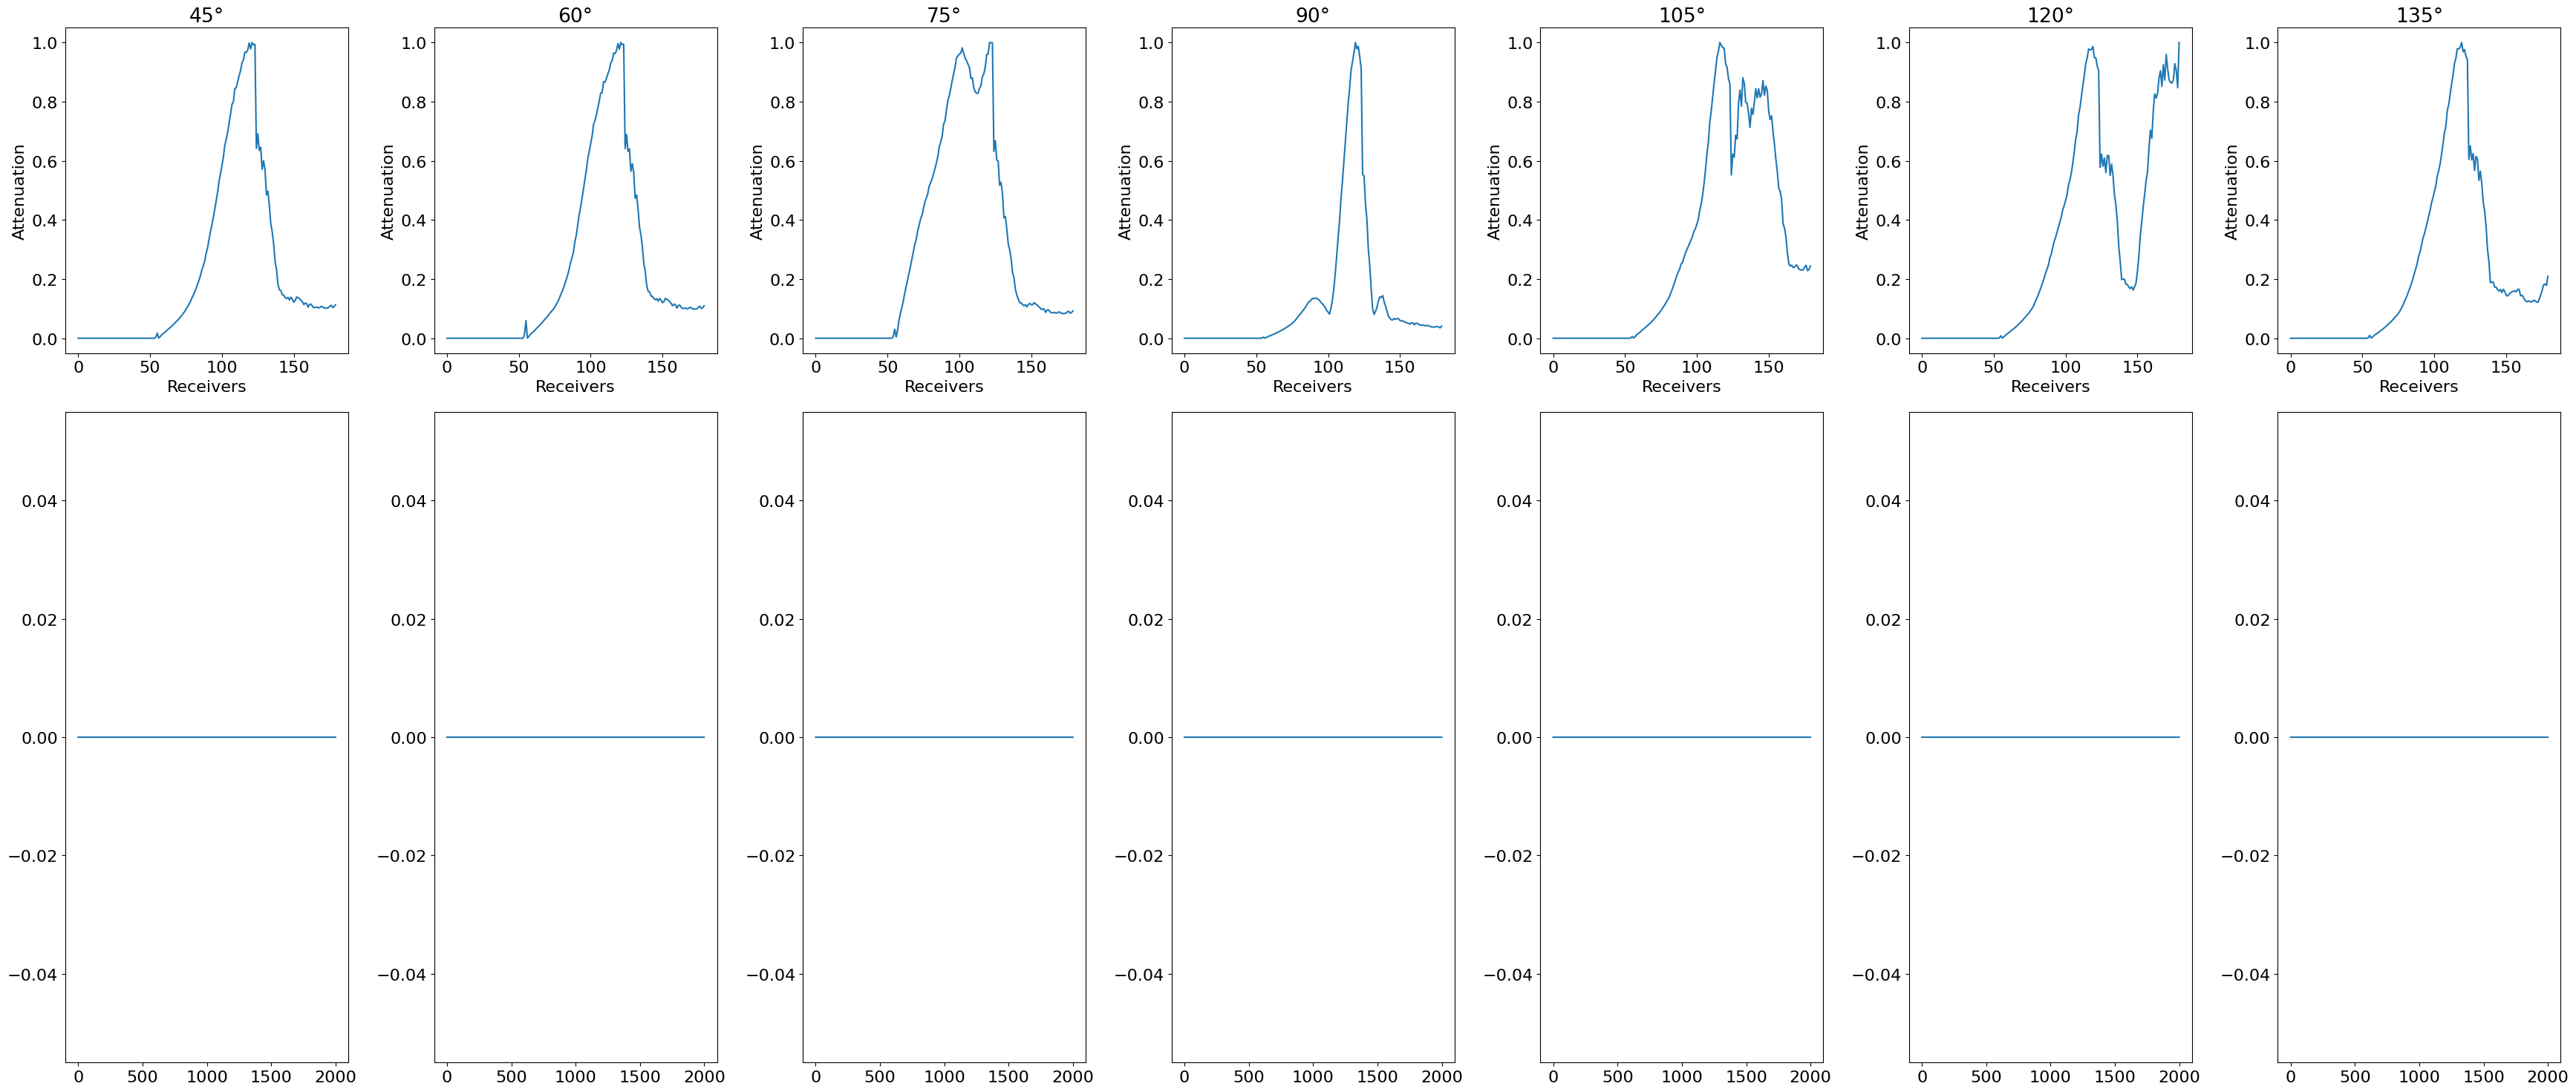

[stderr:1] 
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`
Pickling of `Data` objects is not supported. Casting to `numpy.ndarray`


In [30]:
%%px --no-stream --group-outputs=engine

all_recordings = {a: comm.gather(val, root=0) for a, val in recordings.items()}
if rank == 0:
    all_recordings = {a: np.concatenate(val, axis=1) for a, val in all_recordings.items()}
    
    fig, ax = plt.subplots(2, 7, figsize=(35, 15), gridspec_kw={"height_ratios": [1, 2]})
    for i, (a, r) in enumerate(all_recordings.items()):
        recording = np.flip(r)
        ax[0, i].plot(
            np.max(np.abs(recording[:, :]), axis=0) / np.max(np.abs(recording[:, :]))
        )
        ax[0, i].set_xlabel("Receivers")
        ax[0, i].set_ylabel("Attenuation")
        ax[0, i].set_title(f"{a}°")
        ax[0, i].tick_params()

        ax[1, i].plot(r[6500:8500, 180 - a])
    fig.tight_layout()


## Detection with Correlation

In [3]:
%%px --no-stream --group-outputs=engine

domain_size = (60, 30)
radius = 28
v_env = 1.5
ns = 128
source_distance = 0.002
cy = (ns - 1) / 2 * source_distance + source_distance
f0 = 50
space_order = 8
spatial_dist = round(v_env / f0 / 3, 6)
dt = spatial_dist / 20

In [4]:
%%px --no-stream --group-outputs=engine

sonar = Sonar(
    domain_size,
    f0,
    v_env,
    EllipsisBottom(True),
    space_order=space_order,
    dt=dt,
    spatial_dist=spatial_dist,
)
sonar.set_source()
sonar.set_receiver()
sonar.finalize()

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stderr:0] 
51it [00:01, 25.50it/s]
Operator `initdamp` generated in 0.42 s
  * lowering.IET: 0.19 s (45.5 %)
     * specializing.IET: 0.14 s (33.5 %)
  * lowering.Clusters: 0.16 s (38.3 %)
     * specializing.Clusters: 0.10 s (23.9 %)
Flops reduction after symbolic optimization: [72 --> 72]
Operator `initdamp` fetched `/tmp/devito-jitcache-uid543800157/ff25a25afc1b0e3dc91c4b35109b4adaab240285.cpp` in 0.14 s from jit-cache
Operator `initdamp` ran in 2.88 s
Global performance: [OI=0.22, 0.02 GFlops/s]
Local performance:
  * section0[rank0]<> ran in 0.01 s 
  * section0[rank1]<> ran in 0.01 s 
  * section1[rank0]<254> ran in 0.01 s [OI=0.88, 0.20 GFlops/s, 0.00 GPts/s]
  * section2[rank0]<254,3508> ran in 0.01 s [OI=0.69, 392.06 GFlops/s, 0.00 GPts/s]
  * section3[rank1]<254> ran in 0.01 s [OI=0.88, 0.18 GFlops/s, 0.00 GPts/s]
  * section4[rank1]<254,3508> ran in 0.01 s [OI=0.69, 316.18 GFlops/s, 0.00 GPts/s]
  * section5[rank0]<254> ran in 0.01 s [OI=0.88, 0.23 GFlops/s, 0.00 GPts/s]
  

In [5]:
%%px --no-stream --group-outputs=engine

recording_45 = run_beam(
    sonar.src,
    sonar.rec,
    sonar.op,
    sonar.u,
    sonar.source_distance,
    sonar.time_range,
    sonar.model.critical_dt,
    45,
    v_env,
)

%px:   0%|          | 0/2 [00:00<?, ?tasks/s]

[stdout:0] 
mpicxx -g -fPIC -std=c++11 -gpu=pinned -mp -acc:gpu -fast -shared /tmp/devito-jitcache-uid543800157/1d150efc5a6e1ac464a56883a41dfa99ac112eb3.cpp -lm -o /tmp/devito-jitcache-uid543800157/1d150efc5a6e1ac464a56883a41dfa99ac112eb3.so
Simulation took 66.77610564231873 seconds
[stdout:1] 
Simulation took 66.77397680282593 seconds


[stderr:0] 
Allocating host memory for u(3, 3270, 3524) [264 MB]
Allocating host memory for rec(123139, 64) [60 MB]
Operator `Kernel` jit-compiled `/tmp/devito-jitcache-uid543800157/1d150efc5a6e1ac464a56883a41dfa99ac112eb3.cpp` in 2.49 s with `NvidiaCompiler`
Operator `Kernel` ran in 63.47 s
Global performance: [OI=1.28, 1816.06 GFlops/s, 44.30 GPts/s]
Local performance:
  * section0[rank0]<64> ran in 0.01 s [OI=0.25, 0.01 GFlops/s, 0.00 GPts/s]
  * section0[rank1]<69> ran in 0.01 s [OI=0.25, 0.01 GFlops/s, 0.00 GPts/s]
  * section1[rank0]<123137,3254,3508> ran in 60.66 s [OI=1.28, 950.10 GFlops/s, 23.18 GPts/s]
  * section1[rank1]<123137,3254,3508> ran in 60.71 s [OI=1.28, 949.28 GFlops/s, 23.16 GPts/s]
  * section2[rank0]<<123137,64,2,2>,<123137,64,2,2>> ran in 1.37 s [OI=3.00, 1.40 GFlops/s, 0.03 GPts/s]
  * section2[rank1]<<123137,69,2,2>,<123137,69,2,2>> ran in 1.34 s [OI=3.00, 1.53 GFlops/s, 0.03 GPts/s]
  * section3[rank0]<<123137,64>,<123137,64,2,2>> ran in 1.34 s [OI=0.66, 0.2